In [2]:
# Lots of imports needed
import pandas as pd
import numpy as np
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

In [3]:
# Reading the Data, using a specific sheet name. Starting off by skipping the first 5 rows, because that completely messes up the data.
alb_mbd = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="ALB_MBD", skiprows=5)
pzq = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="PZQ", skiprows=5)
ivm = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="IVM", skiprows=5)

In [5]:
## printing the top two rows, as these are the unformated columns. I used this to figure out which columns I needed for the data.
print(alb_mbd.columns)
print(alb_mbd.loc[0])
print(alb_mbd.loc[1])
#ivm.head()

Index(['Country administrative structure', 'Unnamed: 1', 'Unnamed: 2',
       'Population requiring treatment with ALB/MBD', 'Unnamed: 4',
       'Unnamed: 5', 'Treatment plan', 'Unnamed: 7',
       'People covered by PELF with ALB', 'Loa endemic areas', 'Unnamed: 10',
       'Select medicine for treatment of STH', 'Target population',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Albendazole (ALB)',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Mebendazole (MBD)', 'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')
Country administrative structure                                            Country
Unnamed: 1                                                           Province/State
Unnamed: 2                                                                 District
Population requiring treatment with ALB/MBD                                  PreSAC
Unnamed: 4             

In [8]:
#IVM LF & Oncho
ivm_total_treatment_lf = ivm.iloc[2:, 6]
ivm_total_treatment_oncho = ivm.iloc[2:, 9]
ivm_total_treatment = ivm_total_treatment_lf + ivm_total_treatment_oncho
ivm_total_procured = ivm.iloc[2:, 15] + ivm.iloc[2:, 16]

In [9]:
#Schistosoma
pzq_dist_names = pzq.iloc[2:, 2]
pzq_total_treatment = pzq.iloc[2:, 5]
pzq_tab_procured = pzq.iloc[2:, [16, 17]]
pzq_total_procured = pzq_tab_procured.iloc[:, 0] + pzq_tab_procured.iloc[:, 1]

In [10]:
# Here I selecte the different colummns I  need and store them as seperate Series. The rows start at level 2
# The columns for the first two variables have names, but the rest I find by indexing.
district_names = alb_mbd.loc[2:, "Unnamed: 2"]
total_treatment = alb_mbd.loc[2:, "Population requiring treatment with ALB/MBD"]
total_target_alb = alb_mbd.iloc[2:, 15]
total_target_mbd = alb_mbd.iloc[2:, 19]
lf_alb_tab_bottle = alb_mbd.iloc[2:, 21:23]
sac_alb_tab_bottle = alb_mbd.iloc[2:, 24:26]
sac_mbd_tab_bottle = alb_mbd.iloc[2:, 27:29]

In [11]:
# Checking to see if the data is actually selected
lf_alb_tab_bottle.head(1)

,Unnamed: 21,Unnamed: 22
2,115648,579


In [23]:
# combining the different Series into one dataframe
selectedData = pd.DataFrame({'district_names':district_names, 'total_treatment_alb_mbd':total_treatment, 'total_target_alb':total_target_alb, 'total_target_mbd':total_target_mbd, 'lf_alb_total_procured':lf_alb_tab_bottle.iloc[:,0] + lf_alb_tab_bottle.iloc[:,1], 'sac_alb_total_procured':sac_alb_tab_bottle.iloc[:,0] + sac_alb_tab_bottle.iloc[:,1], 'sth_mbd_total_procured':sac_mbd_tab_bottle.iloc[:,0] + sac_mbd_tab_bottle.iloc[:,1], 
                            'pzq_total_treatment':pzq_total_treatment, 'pzq_total_procured':pzq_total_procured, 'ivm_total_treatment':ivm_total_treatment, 'ivm_total_procured':ivm_total_procured})

# the data is of type string, so here I am just changing everything but the district names to numerics
for col in selectedData.columns:
    if col != 'district_names':
        selectedData[col] = pd.to_numeric(selectedData[col])

# grouping the data by district names and using a mean to aggregate districts that may have multiple rows
# this is probably not the right way to do it, but it was a quick solution
selectedData = selectedData.groupby('district_names').mean().reset_index()
selectedData.head(2)

,district_names,total_treatment_alb_mbd,total_target_alb,total_target_mbd,lf_alb_total_procured,sac_alb_total_procured,sth_mbd_total_procured,pzq_total_treatment,pzq_total_procured,ivm_total_treatment,ivm_total_procured
0,AMAC,209417.0,0.0,502601.0,0.0,0.0,295139.0,255489.00,366847.0,110952.934861,311290.217612
1,Aba North,28912.0,0.0,28912.0,116227.0,0.0,0.0,13357.41,0.0,159677.771632,447992.760568


In [22]:
# loading in geojson
shapefile = '../Data/Nigeria/Nigeria_Shape/AFRO_IUs_201812.shp'
gdf = gpd.read_file(shapefile)
nigeria = gdf[gdf.ADMIN0 == 'Nigeria'].copy()
nigeria.head(3)

,CONTINENT,REGION,WHO_REGION,ADMIN0,ADMIN0ID,ADMIN0_FIP,ADMIN0ISO2,ADMIN0ISO3,ADMIN1,ADMIN1ID,...,IU_ID,IUs_NAME,LASTUPDATE,CARTO,IU_ID2,Alt_IU_Nam,Shape_Leng,Shape_Le_1,Shape_Area,geometry
37,Africa,Western Africa,AFRO,Nigeria,34,NI,NG,NGA,Katsina,3795,...,NGA0379536751,Batangarawa,20160308,GEOCONNECT,36751,None,151893.607155,151893.607155,4.668122e+08,"POLYGON ((7.54951 12.71985, 7.54259 12.69966, ..."
38,Africa,Western Africa,AFRO,Nigeria,34,NI,NG,NGA,Katsina,3795,...,NGA0379536752,Batsari,20160308,GEOCONNECT,36752,None,165691.596815,165691.596815,1.132734e+09,"POLYGON ((7.36951 12.90158, 7.36496 12.85866, ..."
39,Africa,Western Africa,AFRO,Nigeria,34,NI,NG,NGA,Katsina,3795,...,NGA0379536753,Baure,20160308,GEOCONNECT,36753,None,122973.886246,122973.886246,7.773444e+08,"POLYGON ((8.97470 12.83391, 8.97479 12.83336, ..."


In [24]:
# merging the two data sets
merged = nigeria.merge(selectedData, left_on='IUs_NAME', right_on='district_names')
# summing up all the requested columns and dividing them by the target population
merged['mbd_ratio'] = (merged['sth_mbd_total_procured']) / merged['total_target_mbd']
merged['pzq_ratio'] = merged['pzq_total_procured'] / merged['pzq_total_treatment']
merged['ivm_ratio'] = merged['ivm_total_procured'] / merged['ivm_total_treatment']

In [29]:
merged.loc[(pd.isna(merged.pzq_ratio)), 'pzq_ratio'] = 0
merged.loc[(pd.isna(merged.mbd_ratio)), 'mbd_ratio'] = 0
merged.loc[(pd.isna(merged.ivm_ratio)), 'ivm_ratio'] = 0

In [34]:
selectedData.to_csv('filtered_nigeria_data.csv', index=False)

ImportError: The descartes package is required for plotting polygons in geopandas.

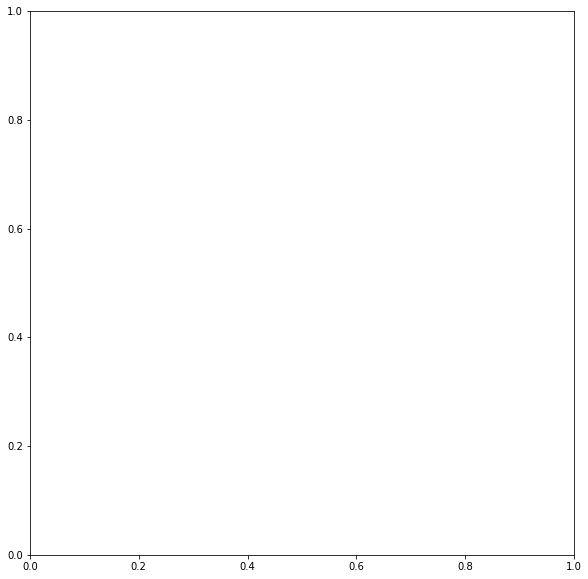

In [27]:
# creating a plot
# any white space is probably a null value, meaning either no data, or something is wrong the data cleaning I did
merged.plot(column='mbd_ratio', legend=True, figsize=(10,10))

ImportError: The descartes package is required for plotting polygons in geopandas.

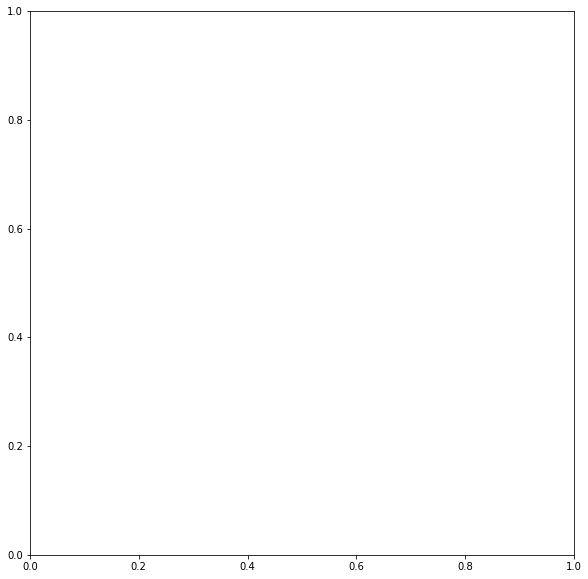

In [28]:
merged.plot(column='pzq_ratio', legend=True, figsize=(10,10))

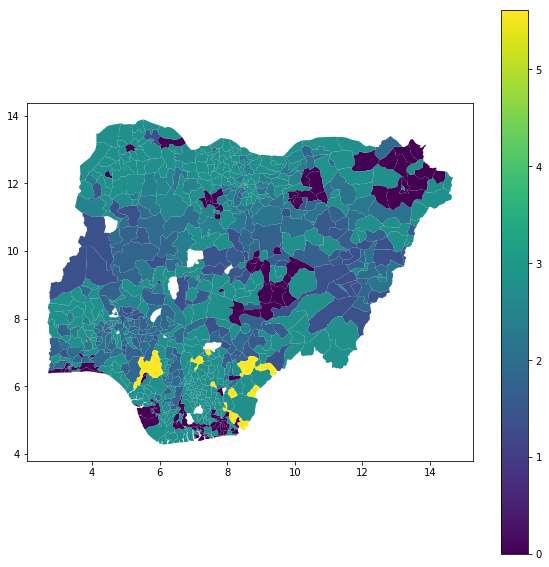

In [16]:
merged.plot(column='ivm_ratio', legend=True, figsize=(10,10))